In [1]:
import warnings; warnings.simplefilter('ignore')

from scipy.io import wavfile
import pandas as pd
import numpy as np
from plotnine import *
theme_set(theme_bw())

# Expanding your regression repetoire with regularisation
*Classifying drum samples with logistic regression including feature selection on features generated using TSfresh*

## Introduction 
For many data scientists, the basic workhorse model is multiple linear regression. It serves as the first port of call in many analyses, and serves as the benchmark for more complicated models. One of its strenghts is the easy interpretability of the resulting coefficients, something that especially neural networks struggle with. However, linear regression is not without its challenges. In this article we focus on one particular challenge: dealing with large sets of features:

- which of the input variables whould we keep, i.e. feature selection?  
- how do we prevent overfitting with a large number of features
- how to deal with correlated features

[Regularisation](https://en.wikipedia.org/wiki/Regularization_(mathematics)) is a very potent technique that deals with the above mentioned issues. Regularisation does this by expanding the normal least squares goal or loss function used in regression with a term which limits the size of coefficients. This can for example be used to perform feature selection if a coefficient is limited to a size of zero.  

In this article you will learn about the following topics:

- What regularisation is in more detail and why it is worthwhile to use
- What different types of regularisation there are, and what the terms L1- and L2-norm mean in this context
- How to practically use regularisation by performing an example analysis
- How to generate features for our regression using tsfresh
- How to interpret and visualise the coefficients of the regularised regression
- How to optimize the regularisation strength using crossvalidation
- How to visualise the outcomes of the crossvalidation

We will start this article off with a more theoretical introduction to regularisation, and finish with a practical example. 

## Why use regularisation and what are norms?
The following figure shows a green and a blue function fitted to the red observations ([attribution](https://commons.wikimedia.org/wiki/File:Regularization.svg)). Both functions perfectly fit the red observations, and we really have no good way of choosing either of the functions using any [loss function](https://en.wikipedia.org/wiki/Loss_function).

![](pics/example_function.png)

Not being able to choose either of these functions means that our problem is *underdetermined*. To break this gridlock we need to add information to our problem. The mathematical term for adding information to our problem is *regularisation*. A very common way to perform regularisation is by expanding the loss function with additional terms. We can for example add the total size of the coefficients to the loss function. A mathematical way to express the total size of the coefficients is using a so called *norm*:

\begin{equation}
\Vert \mathbf{\beta} \Vert_p = (\sum_i |\beta_i|^p)^{1/p}
\end{equation}

where the p value determines what kind of norm we use. A p value of 1 is called an L1 norm, a value of 2 a L2 norm, etc. Now that we have a mathetical epxression for the norm, we can expand the least squares loss function we normally use in regression:

\begin{equation}
L(\beta, \gamma)=\Vert \mathbf{Y} - \mathbf{X\beta} \Vert^2_2 + \lambda \Vert \mathbf{\beta} \Vert_1
\end{equation}

note that we use a L1 norm here, and that we also expressed the squared difference part of the loss function using a L2 norm. When we use an L1 norm in the loss function, this is called [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)) ([sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)). Alternatively, when we use an L2 norm this is called [Ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization) ([sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)). A third option is to use both an L1 and an L2 norm, this is called [Elastic Net regularisation](https://en.wikipedia.org/wiki/Elastic_net_regularization).

- **maybe add references to practical implementations of the various methods.**
- **state that regulaisration can also be used for classification, e.g. through logistic regression**

## Positive properties of regularisation
- **add intuitive explanations of what the norms and thus the two methods do, and when you should apply them**
    - **dealing multicolinearity, e.g. in processing of satellite data. Here it has some ties to PC regression**.
    - **limiting the size of coefficients, trying to prevent ridiculous coefficients out of the fitting process**
    - **feature selection, especially useful in case of many variables of which it is not entirely clear which ones contribute to the solution. Bit of a black box situation**

Ridge regression:
- Deal with highly correlated features. Without the L2 norm the variance in the coefficients of highly correlated variables is very high. A highly positive coefficient is balanced by a highly negative coefficient. 

## Example use of regularisation
### The Dataset

In [2]:
sample_rate, bass = wavfile.read('./sounds/bass1.wav')
bass_pd = pd.DataFrame(bass, columns=['left', 'right']).assign(time_id = range(len(bass)))
bass_pd.head()

,left,right,time_id
0,7,3,0
1,5,4,1
2,12,7,2
3,86,39,3
4,313,182,4


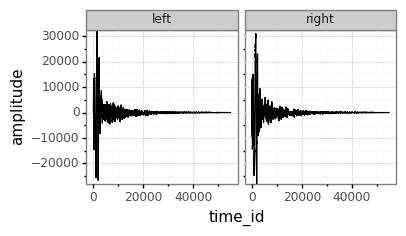

<ggplot: (8739591031225)>

In [3]:
(
    ggplot(bass_pd.melt(id_vars = ['time_id'], value_name='amplitude', var_name='stereo')) 
      + geom_line(aes(x = 'time_id', 
                      y = 'amplitude'))
      + facet_wrap('stereo') 
      + theme(figure_size=(4,2))
)

In [4]:
def audio_to_dataframe(path):
    from scipy.io import wavfile
    
    sample_rate, data = wavfile.read(path)
    ret_obj = (
        pd.DataFrame(data, columns=['left', 'right'])
          .assign(time_id = range(len(data)),
                  file_id = path)
    )
    return ret_obj

import glob

wav_files = glob.glob('sounds/kick/*.wav') + glob.glob('sounds/snare/*.wav') + glob.glob('sounds/tom/*.wav')
all_audio = pd.concat([audio_to_dataframe(path) for path in wav_files])
all_labels = pd.Series(np.repeat(['kick', 'snare', 'tom'], 25), 
                      index = wav_files)
all_audio.head()

,left,right,time_id,file_id
0,234,252,0,sounds/kick/Industrial-Kick-1.wav
1,157,168,1,sounds/kick/Industrial-Kick-1.wav
2,21,26,2,sounds/kick/Industrial-Kick-1.wav
3,472,499,3,sounds/kick/Industrial-Kick-1.wav
4,-138,-150,4,sounds/kick/Industrial-Kick-1.wav


## Generating features

- **What is TSfresh, keep it short and to the point**

In [5]:
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters
settings = MinimalFCParameters()

audio_tsfresh_minimal = extract_relevant_features(all_audio, all_labels, 
                                          column_id='file_id', column_sort='time_id', 
                                          default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 30/30 [00:00<00:00, 181.90it/s]


In [6]:
audio_tsfresh_minimal.shape

(75, 11)

In [7]:
['intercept'] + list(audio_tsfresh_minimal.columns)

['intercept',
 'left__standard_deviation',
 'left__variance',
 'right__standard_deviation',
 'right__variance',
 'right__sum_values',
 'right__mean',
 'left__mean',
 'left__sum_values',
 'left__length',
 'right__length',
 'right__maximum']

In [8]:
from tsfresh.feature_extraction import EfficientFCParameters
settings = EfficientFCParameters()

audio_tsfresh = extract_relevant_features(all_audio, all_labels, 
                                          column_id='file_id', column_sort='time_id', 
                                          default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 30/30 [13:12<00:00, 26.42s/it]


In [9]:
audio_tsfresh.shape

(75, 327)

## Fitting regularised regression
#### Minimal TSfresh vs efficient

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

base_log_reg = LogisticRegression(penalty='l1', 
                                 multi_class='ovr',
                                 solver='saga',
                                 tol=1e-6,
                                 max_iter=int(1e4), 
                                 C=1)

In [11]:
from sklearn.model_selection import train_test_split

def get_score(audio_data, labels):
    # Replace by cross_val_score?
    audio_train, audio_test, label_train, label_test = train_test_split(audio_data, labels, test_size=0.3)
    log_reg = base_log_reg.fit(audio_train, label_train)
    return log_reg.score(audio_test, label_test)
rsquared_minimal = [get_score(audio_tsfresh_minimal, all_labels) for x in range(20)]
rsquared_efficient = [get_score(audio_tsfresh, all_labels) for x in range(20)]

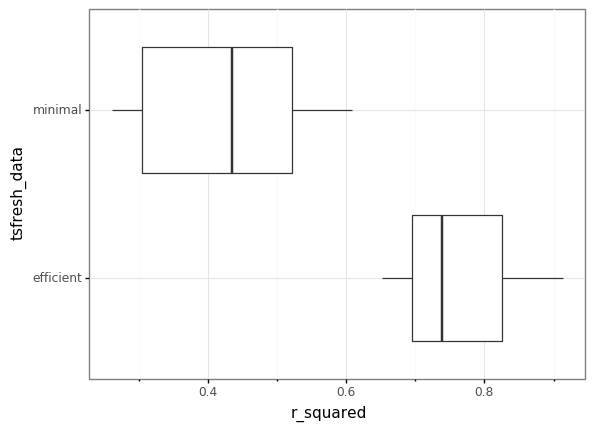

<ggplot: (8739534907837)>

In [12]:
plot_data = pd.concat([pd.DataFrame({'r_squared': rsquared_minimal, 'tsfresh_data': 'minimal'}),
                       pd.DataFrame({'r_squared': rsquared_efficient, 'tsfresh_data': 'efficient'})])
(
    ggplot(plot_data) + geom_boxplot(aes(x='tsfresh_data', y='r_squared')) + coord_flip()
)

#### Coefs versus C

In [13]:
all_labels

sounds/kick/Industrial-Kick-1.wav             kick
sounds/kick/Dry-Kick.wav                      kick
sounds/kick/Kawai-K1r-Rap-Kick.wav            kick
sounds/kick/E-Mu-Proteus-FX-Wacky-Kick.wav    kick
sounds/kick/Kick-Drum-10.wav                  kick
                                              ... 
sounds/tom/Kawai-K5000W-Melo-Tom.wav           tom
sounds/tom/Korg-N1R-Mid-Tom-2.wav              tom
sounds/tom/Hi-Tom-1.wav                        tom
sounds/tom/Low-Tom-1.wav                       tom
sounds/tom/Electro-Tom.wav                     tom
Length: 75, dtype: object

In [14]:
def get_coefs(this_c, X_data=audio_tsfresh_minimal):
    return (
        pd.DataFrame(base_log_reg
                       .set_params(C=this_c)
                       .fit(X_data, all_labels)
                       .coef_
                       .T, 
            index=X_data.columns, 
            columns=['kick', 'snare', 'tom'])
            .assign(C=this_c)
    )
get_coefs(0.0001)

,kick,snare,tom,C
variable,,,,
left__standard_deviation,-4.338686e-09,0.000000e+00,0.000000e+00,0.0001
left__variance,-1.716511e-08,-5.560935e-08,4.149557e-08,0.0001
right__standard_deviation,-5.001520e-09,0.000000e+00,0.000000e+00,0.0001
right__variance,2.277634e-08,1.425036e-08,-7.336448e-08,0.0001
right__sum_values,-2.721662e-07,2.017120e-07,1.331856e-07,0.0001
right__mean,0.000000e+00,0.000000e+00,0.000000e+00,0.0001
left__mean,0.000000e+00,0.000000e+00,0.000000e+00,0.0001
left__sum_values,-2.085703e-07,1.464186e-07,8.691773e-08,0.0001
left__length,-9.911671e-08,-5.527588e-08,3.180538e-08,0.0001


In [15]:
from sklearn.svm import l1_min_c

# Based on https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html#sphx-glr-auto-examples-linear-model-plot-logistic-path-py
cs = l1_min_c(audio_tsfresh_minimal, all_labels, loss='log') * np.logspace(0, 7, 16)

In [16]:
all_coefs_efficient = pd.concat([get_coefs(this_c, audio_tsfresh) for this_c in cs])
x = all_coefs_efficient.reset_index().melt(id_vars = ['C', 'variable'], value_name='coef', var_name='class')

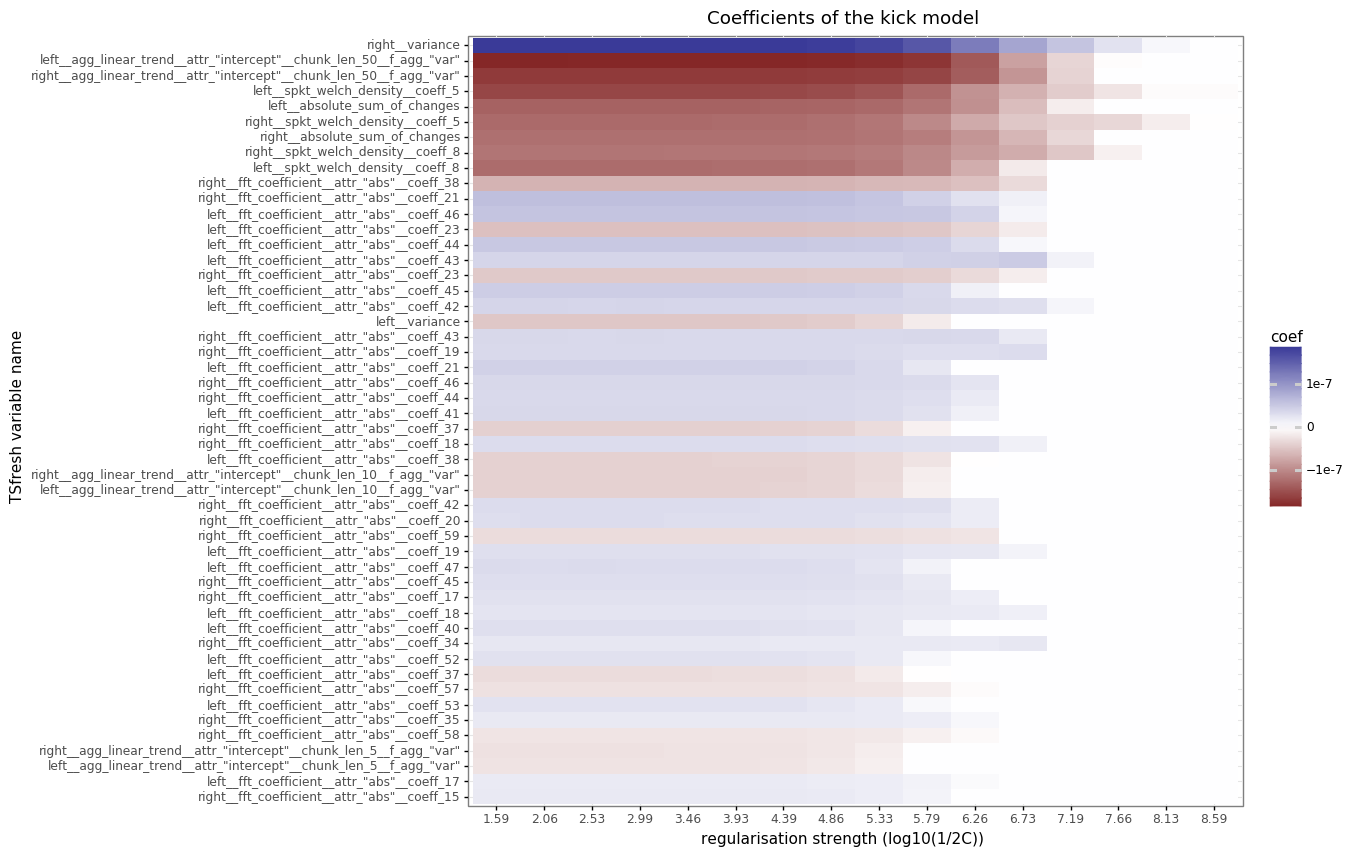

<ggplot: (8739583550957)>

In [17]:
def make_coef_plot(class_of_interest):
    x_only_kick = x[x['class'] == class_of_interest]
    mean_coef_per_variable = x_only_kick.groupby('variable').mean()
    sorted_variables = pd.Series(mean_coef_per_variable['coef'].abs().sort_values(ascending=True).index)
    x_only_kick['variable_sorted'] = pd.Categorical(x_only_kick['variable'], categories=sorted_variables)

    def make_label(nums):
        return ['%0.2f' % np.log10(1/(2*item[0])) for item in nums.items()]

    top40_vars = x_only_kick[x_only_kick['variable_sorted'].isin(sorted_variables.tail(50))]

    return (
        ggplot(top40_vars) + 
         geom_tile(aes(x='factor(C)', y='variable_sorted', fill='coef')) + 
         scale_fill_gradient2() + 
         theme(figure_size=(10,10)) + 
         scale_x_discrete(name = 'regularisation strength (log10(1/2C))', labels=make_label) +
         scale_y_discrete(name = 'TSfresh variable name') + 
         coord_trans(x='reverse') + 
         labs(title='Coefficients of the %s model' % class_of_interest)
    )
make_coef_plot('kick')

Add some interesting observations here:
- **The different models use different variables, The tom model seems to deviate the most**
- **Coefficient size drops stronlgy over the first few features**
- **Increased regularisation strength reduces the coefficients, eliminating the completely after a certain strength. That is inline with our L1 norm we use.**

#### Selecting regularisation strength through crossvalidation
##### Visualising path of the coefficients

In [20]:
cs = l1_min_c(audio_tsfresh_minimal, all_labels, loss='log') * np.logspace(0, 7, 16)
cv_result = LogisticRegressionCV(Cs=cs,
                     penalty='l1', 
                     multi_class='ovr',
                     solver='saga',
                     tol=1e-6,
                     max_iter=int(1e4)).fit(audio_tsfresh, all_labels)

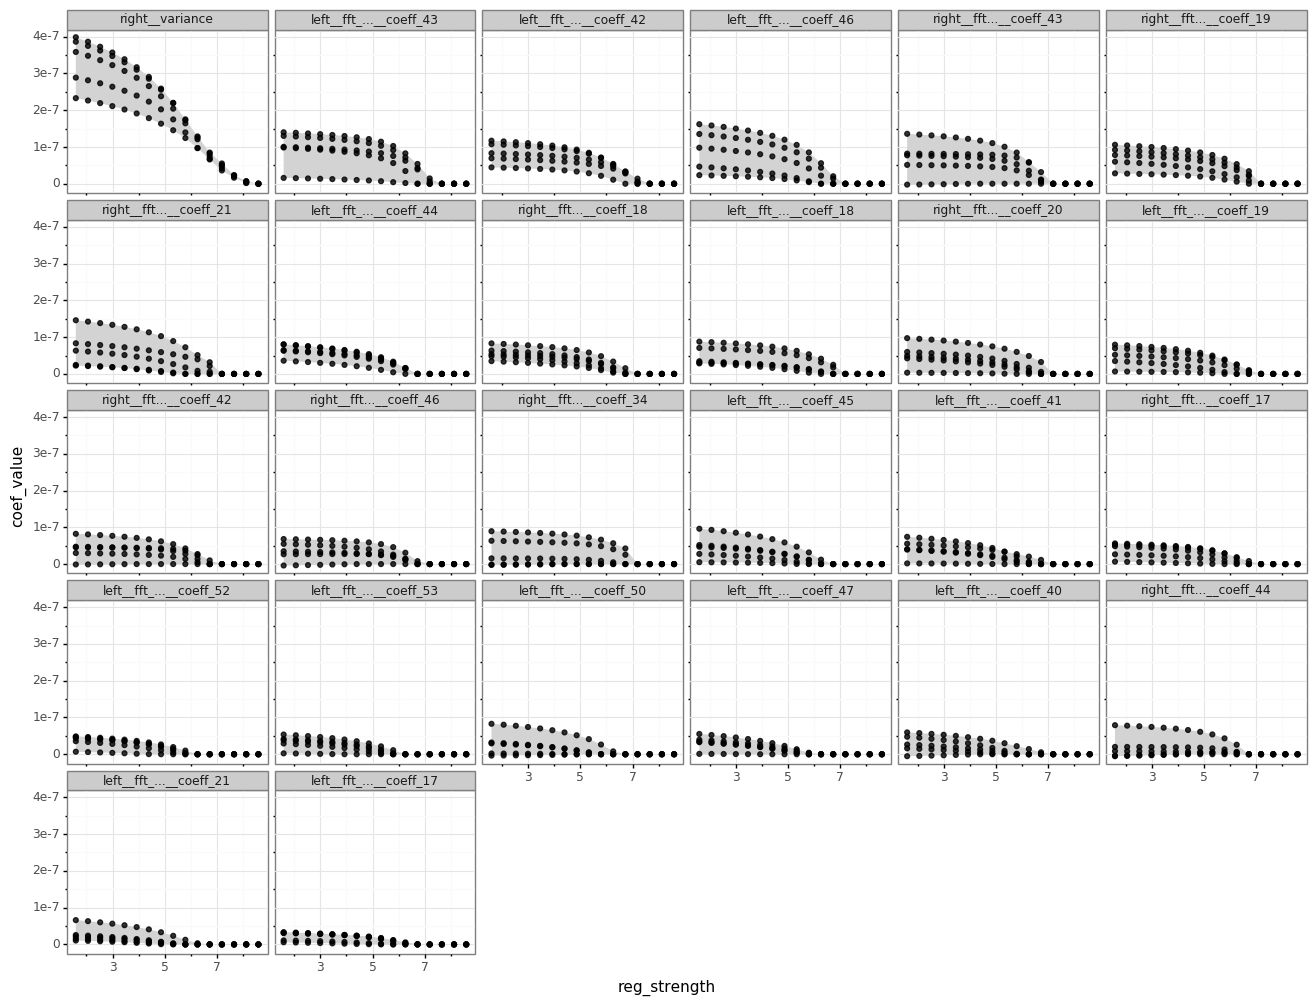

<ggplot: (8739540273297)>

In [54]:
def abbreviate_label(s, max_len=20, connect_string='...'):
    if len(s) > max_len:
        return s[:int(max_len/2)] + connect_string + s[int(-max_len/2):]
    else:
        return s

def plot_coef_paths(cv_results, category, X_data):
    feature_list = pd.Series(range(len(X_data.columns) + 1)) # +1 for intercept
    feature_list.index =  list(X_data.columns) + ['intercept']

    def transform_coef_path(feature_index, feature_name):
        return (
                pd.DataFrame(cv_results.coefs_paths_[category][:,:,feature_index], columns=cs)
                 .melt(var_name='reg_strength', value_name='coef_value')
                 .assign(feature_name=feature_name)
              )
    plot_data = pd.concat([transform_coef_path(value, index) for index, value in feature_list.iteritems()])
    plot_data = plot_data.assign(reg_strength = np.log10(1/(2*plot_data["reg_strength"])))
    mean_coef_values = plot_data.groupby(['feature_name']).mean()
    relevant_features = mean_coef_values.query('coef_value > 1e-8').index
    plot_data = plot_data[plot_data['feature_name'].isin(relevant_features)]

    coef_from_high_to_low = plot_data.groupby(['feature_name']).mean().abs().sort_values(by='coef_value', ascending=False).index
    plot_data['feature_name'] = pd.Categorical(plot_data['feature_name'], categories=coef_from_high_to_low)

    plot_data_min_max = plot_data.groupby(['reg_strength', 'feature_name']).agg(['min', 'max'])
    plot_data_min_max.columns = ['_'.join(col).strip() for col in plot_data_min_max.columns.values] 
    plot_data_min_max = plot_data_min_max.reset_index()

    return (
        ggplot(plot_data) + 
          geom_ribbon(plot_data_min_max, aes(x='reg_strength', ymin='coef_value_min', ymax='coef_value_max'), fill='lightgrey') + 
          geom_point(aes(x='reg_strength', y='coef_value'), alpha=0.8) + 
          facet_wrap('~ feature_name', labeller=abbreviate_label) 
    )
plot_coef_paths(cv_result, 'kick', audio_tsfresh) + theme(figure_size=(16,12))

##### Visualising overall performance

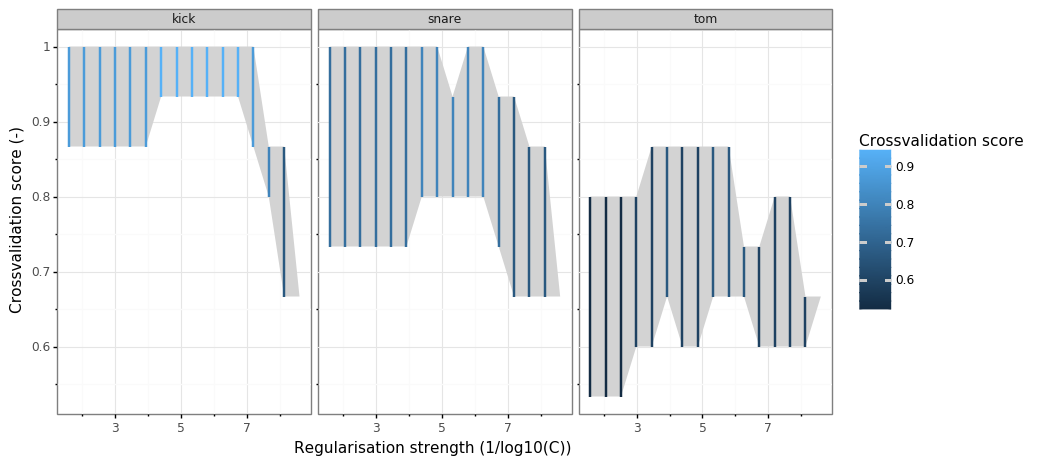

<ggplot: (8739586196453)>

In [25]:
def get_data_per_model(data_for_model, model_name, cs_values):
    plot_data = (
        pd.DataFrame(data_for_model, columns=cs_values)
          .melt(var_name='reg_strength', value_name='cv_score')
          .groupby('reg_strength')
          .agg(['min', 'max'])
    )

    # Strip multi-index to single index (https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns)
    plot_data.columns = ['_'.join(col).strip() for col in plot_data.columns.values] 
    plot_data = plot_data.reset_index()
    return plot_data.assign(reg_strength = np.log10(1/(2*plot_data["reg_strength"])),
                            model_name = model_name)

def plot_reg_strength_vs_score(cv_results):
    plot_data = pd.concat([get_data_per_model(cv_results.scores_[mod], mod, cv_results.Cs_) for mod in cv_results.scores_])

    return (
        ggplot(plot_data) + 
          geom_ribbon(aes(x='reg_strength', ymin='cv_score_min', ymax='cv_score_max'), fill='lightgrey') + 
          geom_segment(aes(x='reg_strength', xend='reg_strength', y='cv_score_min', yend='cv_score_max', color='cv_score_min'), size=1) + 
          scale_color_gradient() + 
          facet_wrap('~ model_name') + 
          labs(x='Regularisation strength (1/log10(C))', y = 'Crossvalidation score (-)', color='Crossvalidation score')
    )
plot_reg_strength_vs_score(cv_result) + theme(figure_size=(10,5))

Observations:
- Tom has the worst performing model with the lowest overall score.
- Kick performs best with the highest minimum score
- Performance peaks between a regularisation strength of 5-6. With a smaller strength I suspect too much noise from the superfluous variables, after that the regularisation takes out too much variables and thus information. 

In [26]:
np.log10(1/(2*cv_result.C_))

array([6.72667956, 6.2600129 , 4.8600129 ])

## The case for Lasso as a baseline model

Lasso goed:
- Snel
- Kan feature selectie doen iets meer fire and forget
- Feature selectie kan via cross-validatie
- Coef zijn nog interpreteerbaar, dit maakt het ook tot een goede data verkenningsmethode
- Vormt een mooie benchmark voor meer complexe methodes zoals Gradient Boosting Machines. 